In [1]:
from PIL import Image
import numpy as np

#### load training images into train_imgs

In [2]:
train_imgs = np.zeros((40,7,2576))
for c in range(40):
    for n in range(7):
        img = Image.open('hw2_data/hw2-2_data/{}_{}.png'.format(c+1,n+1)).convert('L')
        img_as_np = np.asarray(img)
        train_imgs[c][n] = img_as_np.reshape(-1)

In [3]:
train_imgs.shape

(40, 7, 2576)

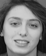

In [5]:
Image.fromarray(train_imgs[7][5].reshape(56,46).astype('uint8'))

#### get average face

In [6]:
train_average_face = train_imgs.mean(axis=(0,1))

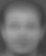

In [8]:
Image.fromarray(train_average_face.reshape(56,46).astype('uint8'))

In [10]:
im = Image.fromarray(train_average_face.reshape(56,46).astype('uint8'))
im.save("train_average_face.jpg")

#### calculate cov_matrix and eigenfaces

In [11]:
train_cov_matrix = np.cov(train_imgs.reshape(-1,2576).T)

In [13]:
train_eig_vals, train_eig_vecs = np.linalg.eig(train_cov_matrix)
train_eig_vecs = train_eig_vecs.astype(float)
train_eig_vals = train_eig_vals.astype(float)

/Users/maoredman/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  
/Users/maoredman/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
np.save('train_eig_vecs', train_eig_vecs)

## PCA only

#### get eigenfaces

In [22]:
for i in range(5):
    pixel_range = train_eig_vecs[:,i].max() - train_eig_vecs[:,i].min()
    pixel_delta = train_eig_vecs[:,i] - train_eig_vecs[:,i].min()
    pixel_normalized = pixel_delta * 255 / pixel_range
    im = Image.fromarray(pixel_normalized.reshape(56,46).astype('uint8'))
    im.save("eigenface_{}.jpg".format(i+1))

#### reconstruct an image

In [19]:
img = Image.open('hw2_data/hw2-2_data/8_6.png').convert('L')
img_as_np = np.asarray(img).astype(float)
img_as_np = img_as_np.reshape(-1)

In [25]:
for eigenfaces_used in [5,50,150,279]:
    coeff = (img_as_np - train_average_face).dot(train_eig_vecs[:,0:eigenfaces_used])
    reconstructed_img = train_eig_vecs[:,0:eigenfaces_used].dot(coeff)
    reconstructed_img = reconstructed_img + train_average_face
    # print(coeff.shape)
    # print(reconstructed_img.shape)
    print('used {}, reconstruction error {}'.format(eigenfaces_used, np.mean((reconstructed_img - img_as_np)**2)))
    im = Image.fromarray(reconstructed_img.reshape(56,46).astype('uint8'))
    im.save("reconstruct_with_{}.jpg".format(eigenfaces_used))

used 5, reconstruction error 693.7021744253194
used 50, reconstruction error 119.20025848187896
used 150, reconstruction error 38.75113372522805
used 279, reconstruction error 1.6014640738105883e-24


#### use t-SNE to visualize test images

In [285]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [422]:
test_imgs = np.zeros((40,3,2576))
for c in range(40):
    for n in range(7,10):
        img = Image.open('hw2_data/hw2-2_data/{}_{}.png'.format(c+1,n+1)).convert('L')
        img_as_np = np.asarray(img)
        test_imgs[c][n-7] = img_as_np.reshape(-1)

In [424]:
test_imgs.shape

(40, 3, 2576)

In [425]:
eigenfaces_used = 100
imgs_dim_reduced = test_imgs.dot(train_eig_vecs[:,0:eigenfaces_used])

In [426]:
imgs_dim_reduced.shape

(40, 3, 100)

In [427]:
imgs_tsne = TSNE(n_components=2).fit_transform(imgs_dim_reduced.reshape(-1,100))
# X.shape == (len(X), n_components)

In [428]:
imgs_tsne.shape

(120, 2)

In [429]:
list_of_colors = ['xkcd:{}'.format(name) for name in ["cloudy blue","dark pastel green","dust","electric lime","fresh green","light eggplant","nasty green","really light blue","tea","warm purple","yellowish tan","cement","dark grass green","dusty teal","grey teal","macaroni and cheese","pinkish tan","spruce","strong blue","toxic green","windows blue","blue blue","blue with a hint of purple","booger","bright sea green","dark green blue","deep turquoise","green teal","strong pink","bland","deep aqua","lavender pink","light moss green","light seafoam green","olive yellow","pig pink","deep lilac","desert","dusty lavender","purpley grey"]]

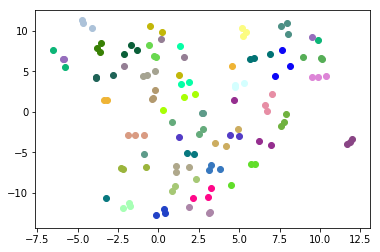

In [430]:
# list_of_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
color_cycler = itertools.cycle(list_of_colors)
for idx, thing in enumerate(imgs_tsne):
    if idx %3 == 0:
        chosen_color = next(color_cycler)
    plt.scatter(thing[0], thing[1], color=chosen_color)
# myplot = plt.scatter(imgs_tsne[:,0], imgs_tsne[:,1], color=next(colors))
plt.savefig('PCA_TSNE.png', dpi=150)

## LDA only

In [31]:
train_eig_vecs = np.load('train_eig_vecs.npy')

In [32]:
np.save('train_PCA_vecs', train_eig_vecs[:,0:279])

In [33]:
C = 40
N = 280
eigenfaces_used = N-C
train_img_PCA_coeff = (train_imgs - train_average_face).dot(train_eig_vecs[:,0:eigenfaces_used])

In [34]:
train_img_PCA_coeff.shape

(40, 7, 240)

In [35]:
S_W = np.zeros((eigenfaces_used,eigenfaces_used))

In [36]:
for c in range(len(train_imgs)):
    class_mean = train_img_PCA_coeff[c].mean(axis=0)
    x_minus_u = train_img_PCA_coeff[c] - class_mean
    S_W += (x_minus_u.T).dot(x_minus_u)

In [37]:
PCA_global_mean = train_img_PCA_coeff.mean(axis=(0,1))
u_class_minus_u_global = train_img_PCA_coeff.mean(1) - PCA_global_mean
S_B = (u_class_minus_u_global.T).dot(u_class_minus_u_global)

In [38]:
from numpy.linalg import inv

In [39]:
LDA_eig_vals, W = np.linalg.eig(inv(S_W).dot(S_B))

In [40]:
LDA_eig_vals = LDA_eig_vals.astype(float)
W = W.astype(float)

/Users/maoredman/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.
/Users/maoredman/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [41]:
np.save('train_LDA_vecs', W[:,0:C-1])

In [42]:
fisherfaces = train_eig_vecs[:,0:eigenfaces_used].dot(W[:,0:C-1])

In [43]:
fisherfaces.shape

(2576, 39)

In [44]:
for i in range(5):
    pixel_range = fisherfaces[:,i].max() - fisherfaces[:,i].min()
    pixel_delta = fisherfaces[:,i] - fisherfaces[:,i].min()
    pixel_normalized = pixel_delta * 255 / pixel_range
    im = Image.fromarray((pixel_normalized).astype('uint8').reshape(56,46))
    im.save("fisherface_{}.jpg".format(i+1))

#### use t-SNE to visualize test images

In [316]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [319]:
test_imgs = np.zeros((40,3,2576))
for c in range(40):
    for n in range(7,10):
        img = Image.open('hw2_data/hw2-2_data/{}_{}.png'.format(c+1,n+1)).convert('L')
        img_as_np = np.asarray(img)
        test_imgs[c][n-7] = img_as_np.reshape(-1)

In [325]:
test_imgs.shape

(40, 3, 2576)

In [330]:
test_imgs_PCA_coeff = (test_imgs - train_average_face).dot(train_eig_vecs[:,0:eigenfaces_used])

In [331]:
test_imgs_PCA_coeff.shape

(40, 3, 240)

In [332]:
fisherfaces_used = 30
test_imgs_LDA_coeff = test_imgs_PCA_coeff.dot(W[:,0:fisherfaces_used])

In [333]:
test_imgs_LDA_coeff.shape

(40, 3, 30)

In [336]:
imgs_tsne = TSNE(n_components=2).fit_transform(test_imgs_LDA_coeff.reshape(-1,30))

In [357]:
import itertools, random

In [364]:
list_of_colors = ['xkcd:{}'.format(name) for name in ["cloudy blue","dark pastel green","dust","electric lime","fresh green","light eggplant","nasty green","really light blue","tea","warm purple","yellowish tan","cement","dark grass green","dusty teal","grey teal","macaroni and cheese","pinkish tan","spruce","strong blue","toxic green","windows blue","blue blue","blue with a hint of purple","booger","bright sea green","dark green blue","deep turquoise","green teal","strong pink","bland","deep aqua","lavender pink","light moss green","light seafoam green","olive yellow","pig pink","deep lilac","desert","dusty lavender","purpley grey"]]

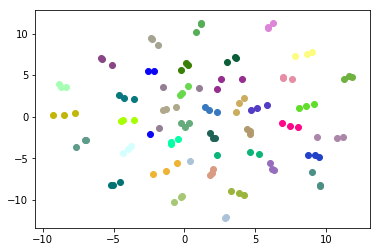

In [369]:
# list_of_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
color_cycler = itertools.cycle(list_of_colors)
for idx, thing in enumerate(imgs_tsne):
    if idx %3 == 0:
        chosen_color = next(color_cycler)
    plt.scatter(thing[0], thing[1], color=chosen_color)
# myplot = plt.scatter(imgs_tsne[:,0], imgs_tsne[:,1], color=next(colors))
plt.savefig('LDA_TSNE.png', dpi=150)